# Setup
[Project Description](https://docs.google.com/document/d/1U7U4PN39LvbMh9_PGCAjtJU7BS_omKqtc081Qqbcvlg/edit)

## imports

In [1]:
import cv2
import glob
import numpy as np
import sys
print(sys.version)
print("OpenCV version :  {0}".format(cv2.__version__))

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
OpenCV version :  4.2.0


In [2]:
import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()


## Camera parameter matrices

In [3]:
left_intrinsic = np.array([[423.27381306, 0, 341.34626532],
                           [0, 421.27401756, 269.28542111],
                           [0, 0, 1]])

right_intrinsic = np.array([[420.91160482, 0, 352.16135589],
                            [0, 418.72245958, 264.50726699],
                            [0, 0, 1]])

distCoeffs_left = np.array([-0.43394157423038077, 0.26707717557547866,
                             -0.00031144347020293427, 0.0005638938101488364,
                             -0.10970452266148858])
distCoeffs_right = np.array([-0.4145817681176909, 0.19961273246897668,
                             -0.00014832091141656534, -0.0013686760437966467,
                             -0.05113584625015141])

In [4]:
left_intrinsic

array([[423.27381306,   0.        , 341.34626532],
       [  0.        , 421.27401756, 269.28542111],
       [  0.        ,   0.        ,   1.        ]])

# Step 1: Load the images

In [5]:
left_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_5/left_*.png"))]
right_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_5/right_*.png"))]

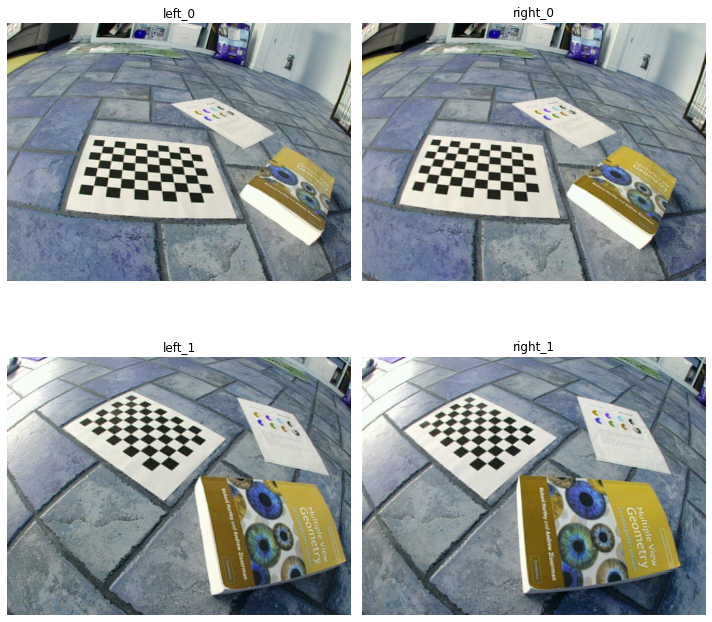

In [6]:
plot_figures({'left_0': left_[0], 'right_0': right_[0], 'left_1': left_[1], 'right_1': right_[1]}, 2, 2)

# Step 2: Undistort the images

In [7]:
def undistortImage(img, mtx, distCoeffs):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,distCoeffs,(w,h),0,(w,h))

#     dst = cv2.undistort(img, mtx, distCoeffs, None, newcameramtx)

    mapx, mapy = cv2.initUndistortRectifyMap(left_intrinsic, distCoeffs_left, None, newcameramtx, (w,h), 5)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # crop the image
    x,y,w,h = roi
    return dst[y:y+h, x:x+w]

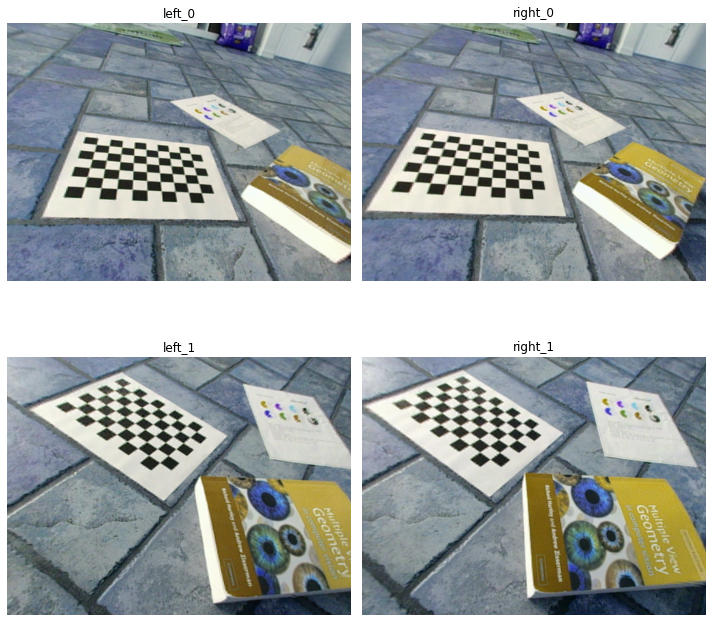

In [8]:
for i in range(len(left_)):
    left_[i] = undistortImage(left_[i], left_intrinsic, distCoeffs_left)

for i in range(len(right_)):
    right_[i] = undistortImage(right_[i], right_intrinsic, distCoeffs_right)
    
plot_figures({'left_0': left_[0], 'right_0': right_[0], 'left_1': left_[1], 'right_1': right_[1]}, 2, 2)    

## get 2D points - 2D points

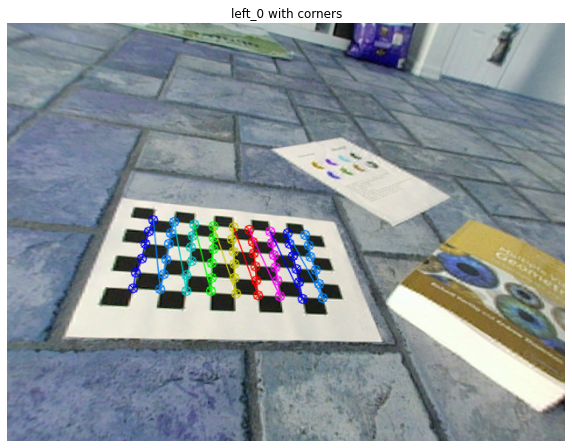

In [9]:
retval, corners_2D = cv2.findChessboardCorners(left_[0],(6,9))
# print(retval,corners_2D)

corner_img = left_[0].copy()
cv2.drawChessboardCorners(corner_img,(6,9),corners_2D,retval)
plot_figures({'left_0 with corners': corner_img})

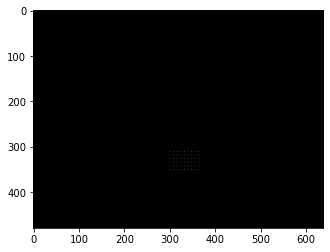

In [12]:
# black[vertical][horizontal]
black = np.zeros(left_[0].shape[:2])

for i in range(9):
    for j in range(6):
        black[350 - j*8][300 + i*8] = 1

plt.imshow(black)

In [33]:
dstPoints = []

for i in range(9):
    for j in range(6):
        dstPoints.append([250 + i*8, 400 - j*8])
        
dstPoints = np.array(dstPoints)
dstPoints = dstPoints.reshape((54,1,2))
dstPoints.shape

(54, 1, 2)

### Verify Correct correspondance

In [14]:
print(corners_2D[0], corners_2D[1])
print(dstPoints[0], dstPoints[1])

[[144.44733 303.881  ]] [[146.54045 285.5219 ]]
[[350 300]] [[350 292]]


In [15]:
print(corners_2D[6], corners_2D[7])
print(dstPoints[6], dstPoints[7])

[[174.76753 304.58145]] [[178.63655 288.28738]]
[[358 300]] [[358 292]]


# Step 3: findHomography
[findHomography()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=findhomography#findhomography)

cv2.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask]]]) → retval, mask

In [34]:
H, mask = cv2.findHomography(corners_2D, dstPoints)

# Step 4: Warp the Image

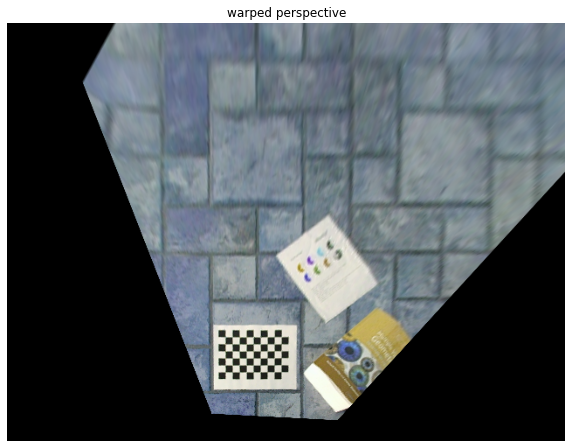

In [36]:
left_0_warped = cv2.warpPerspective(left_[0].copy(), H, (left_[0].shape[:2][1],left_[0].shape[:2][0]))

plot_figures({'warped perspective':left_0_warped},1,1)

# Warp Another Image

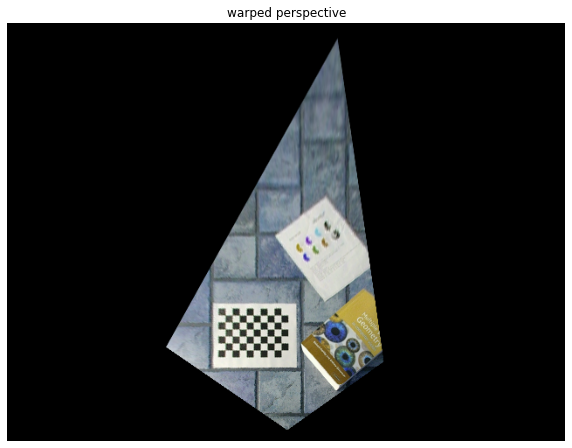

In [43]:
retval, corners_2D = cv2.findChessboardCorners(left_[1],(6,9))

dstPoints = []

for i in range(9):
    for j in range(6):
        dstPoints.append([250 + i*8, 375 - j*8])
        
dstPoints = np.array(dstPoints)
dstPoints = dstPoints.reshape((54,1,2))

H, mask = cv2.findHomography(corners_2D, dstPoints)

left_1_warped = cv2.warpPerspective(left_[1].copy(), H, (left_[1].shape[:2][1],left_[1].shape[:2][0]))

plot_figures({'warped perspective':left_1_warped},1,1)

### Output to png

In [ ]:
cv2.imwrite('../../output/task_2/left_1_right_1_rectified.png', out)
cv2.imwrite('../../output/task_2/left_1_right_1_rectified.png', out)